In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(50, 90, 41)

df = pd.read_csv('2017-03-16_PRO_multi_well_inference_input_multi_well_t_50.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[:41,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((41,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

print(st_dev)

print(np.mean(org_values, axis=1))
print(centred_moment_3)

# print(centred_moments.shape)


[15.4219608  15.8269359  15.11067503 15.64338838 14.10901839 15.53534277
 15.8091619  14.17992948 15.35479078 14.74019929 14.24164316 14.78246935
 14.1964573  14.07045131 14.07892396 14.06163131 13.94908151 13.44175956
 13.4986629  13.30276193 13.87695932 13.12284649 11.60885007 12.24704454
 11.89526797 12.06114008 11.64801593 11.69198443 11.57082106 11.31704909
 10.94109112 11.44934387 10.65208313 11.21911761 10.49744135 10.45737061
 10.17435379 10.16638948 10.20910868  9.88020622  9.31039204]
[4.525 4.59  4.55  4.62  4.34  4.575 4.52  4.36  4.52  4.405 4.34  4.44
 4.34  4.32  4.33  4.305 4.275 4.21  4.19  4.095 4.1   4.03  3.86  3.93
 3.76  3.83  3.785 3.75  3.69  3.62  3.495 3.495 3.425 3.42  3.285 3.28
 3.245 3.205 3.21  3.155 3.04 ]
[22868.93596875 26195.498958   21226.5075     24129.213156
 17381.852508   23671.02028125 25809.841716   17287.939812
 22534.323816   20401.81754775 17571.727308   19888.751568
 17197.025508   16630.006236   16218.762624   16155.21290775
 15457.1320312

Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 25
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
noise_arr[0] = 1
noise_arr[1] = 1
noise_arr[2] = 1
noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 6


Create uniform log prior

In [5]:

# Define the size of the list
size = 6
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.000001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 100
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_7454/4001140987.py:27: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.4
1     462     0:02.1
2     870     0:03.7
3     1323    0:05.4
20    7674    0:27.6
40    13533   0:48.9
60    19128   1:08.2
80    23874   1:24.7
100   28707   1:41.6
120   33597   1:58.4
140   38343   2:15.0
160   43080   2:31.4
180   48084   2:48.8
200   53190   3:06.2
220   58266   3:23.6
240   63435   3:41.4
260   68532   3:58.8
280   73731   4:16.8
300   78876   4:34.4
320   84291   4:52.7
340   89169   5:09.5
360   94230   5:26.9
380   99381   5:44.7
400   104601   6:02.7
420   109749   6:20.6
440   114969   6:38.2
460   120057   6:55.5
480   125232   7:13.0
500   130440   7:30.7
520   135507   7:48.1
540   140763   8:08.2
560   145962   8:26.8
580   151095   8:43.9
600   156348   9:01.6
620   161517   9:18.9
640   166713   9:36.2
660   172068   9:55.0
680   177333  10:12.9
700   182511  10:30.0
720   187713  10:47.8
740   192837  11:05.3
760   198084  11:23

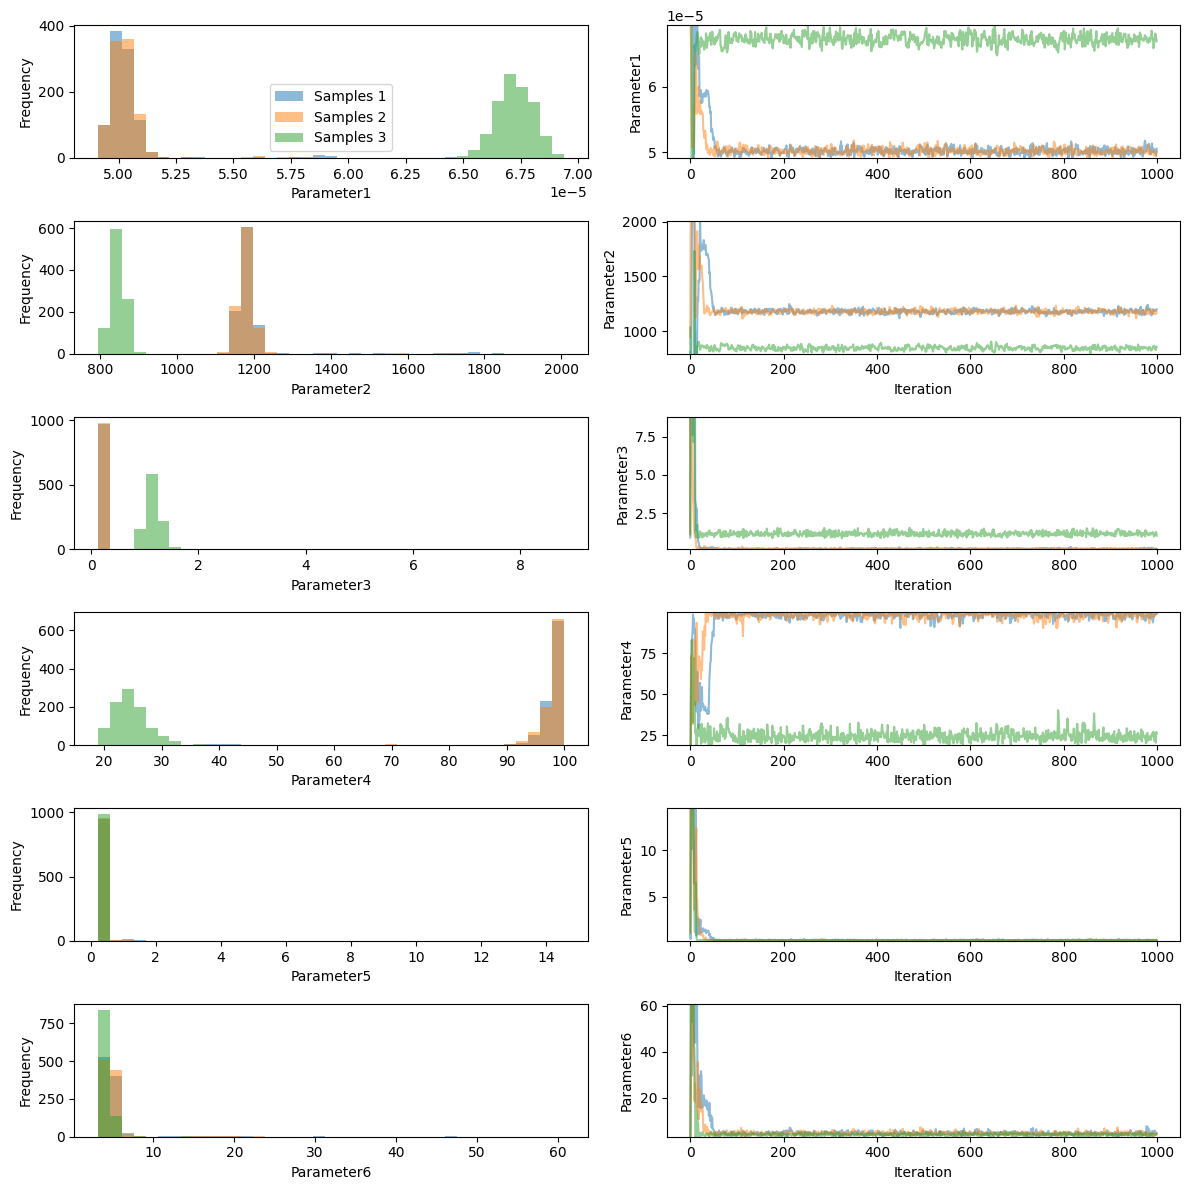

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()

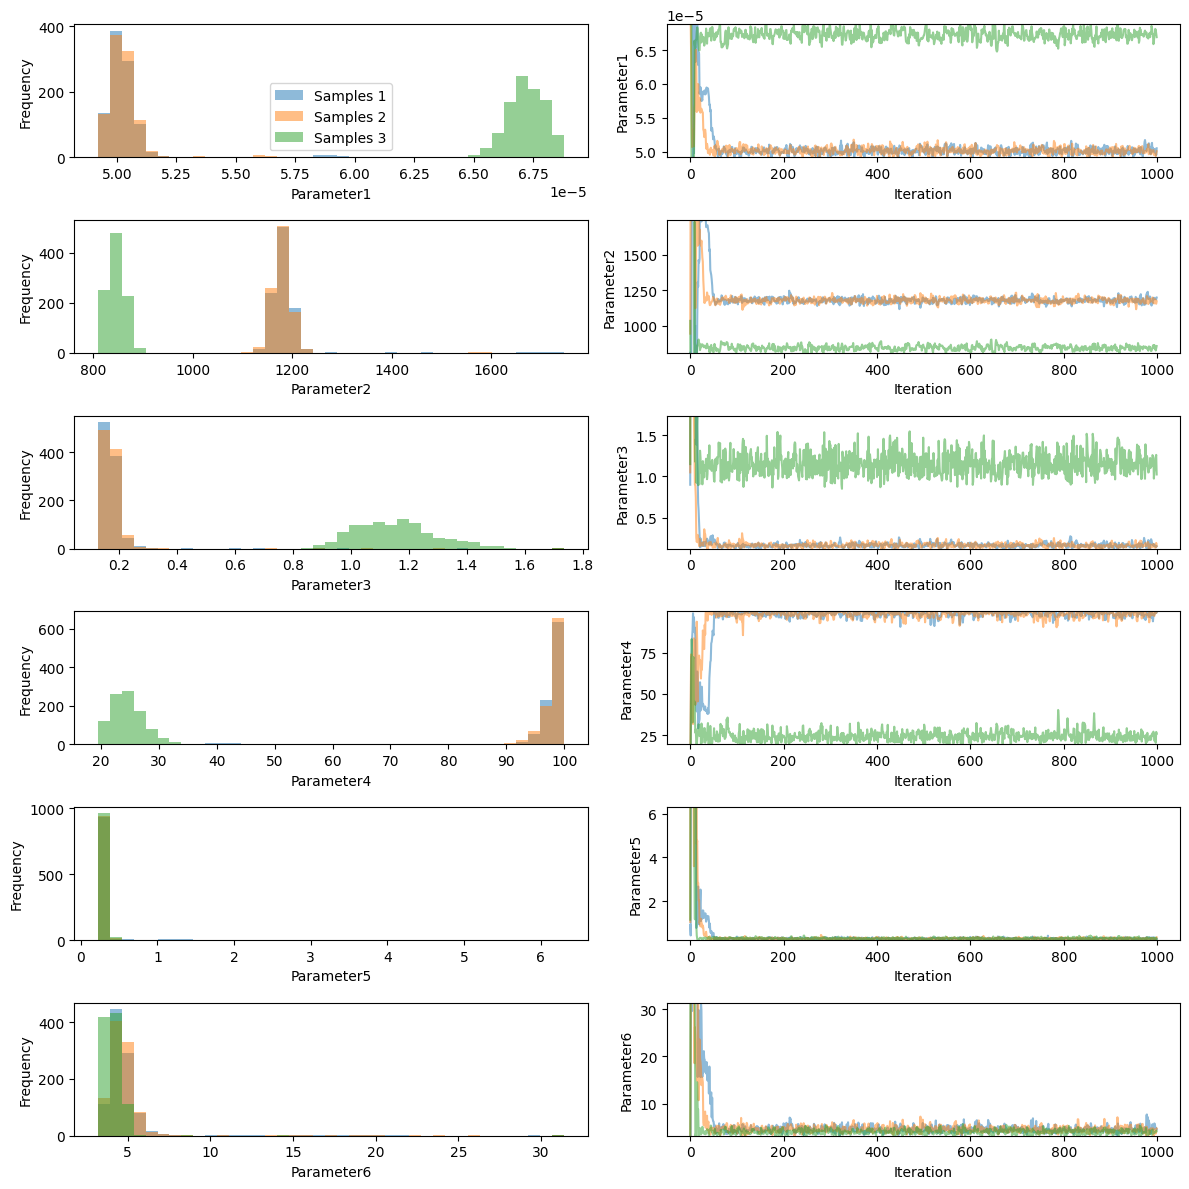

In [8]:
pints.plot.trace(chains, n_percentiles=98)
plt.savefig("mcmc.png")
plt.show()


In [9]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 6)
[4.98922302e-05 1.18791874e+03 1.67010021e-01 9.72772968e+01
 3.76970292e-01 4.02092347e+00]
[[4.98922302e-05 1.18791874e+03 1.67010021e-01 9.72772968e+01
  3.76970292e-01 4.02092347e+00]
 [5.02241212e-05 1.18534799e+03 1.72362620e-01 9.81341599e+01
  3.16735298e-01 3.57441097e+00]
 [4.97200297e-05 1.15150373e+03 1.95808618e-01 9.89585057e+01
  3.11393894e-01 4.03577107e+00]
 ...
 [5.01075932e-05 1.19141432e+03 1.52034824e-01 9.89337879e+01
  2.62463796e-01 4.77201013e+00]
 [4.94999752e-05 1.18653157e+03 1.45880814e-01 9.97546354e+01
  2.41895585e-01 4.81161072e+00]
 [5.05130157e-05 1.19944786e+03 1.55732188e-01 9.92179726e+01
  2.87198738e-01 4.54153649e+00]]


In [10]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


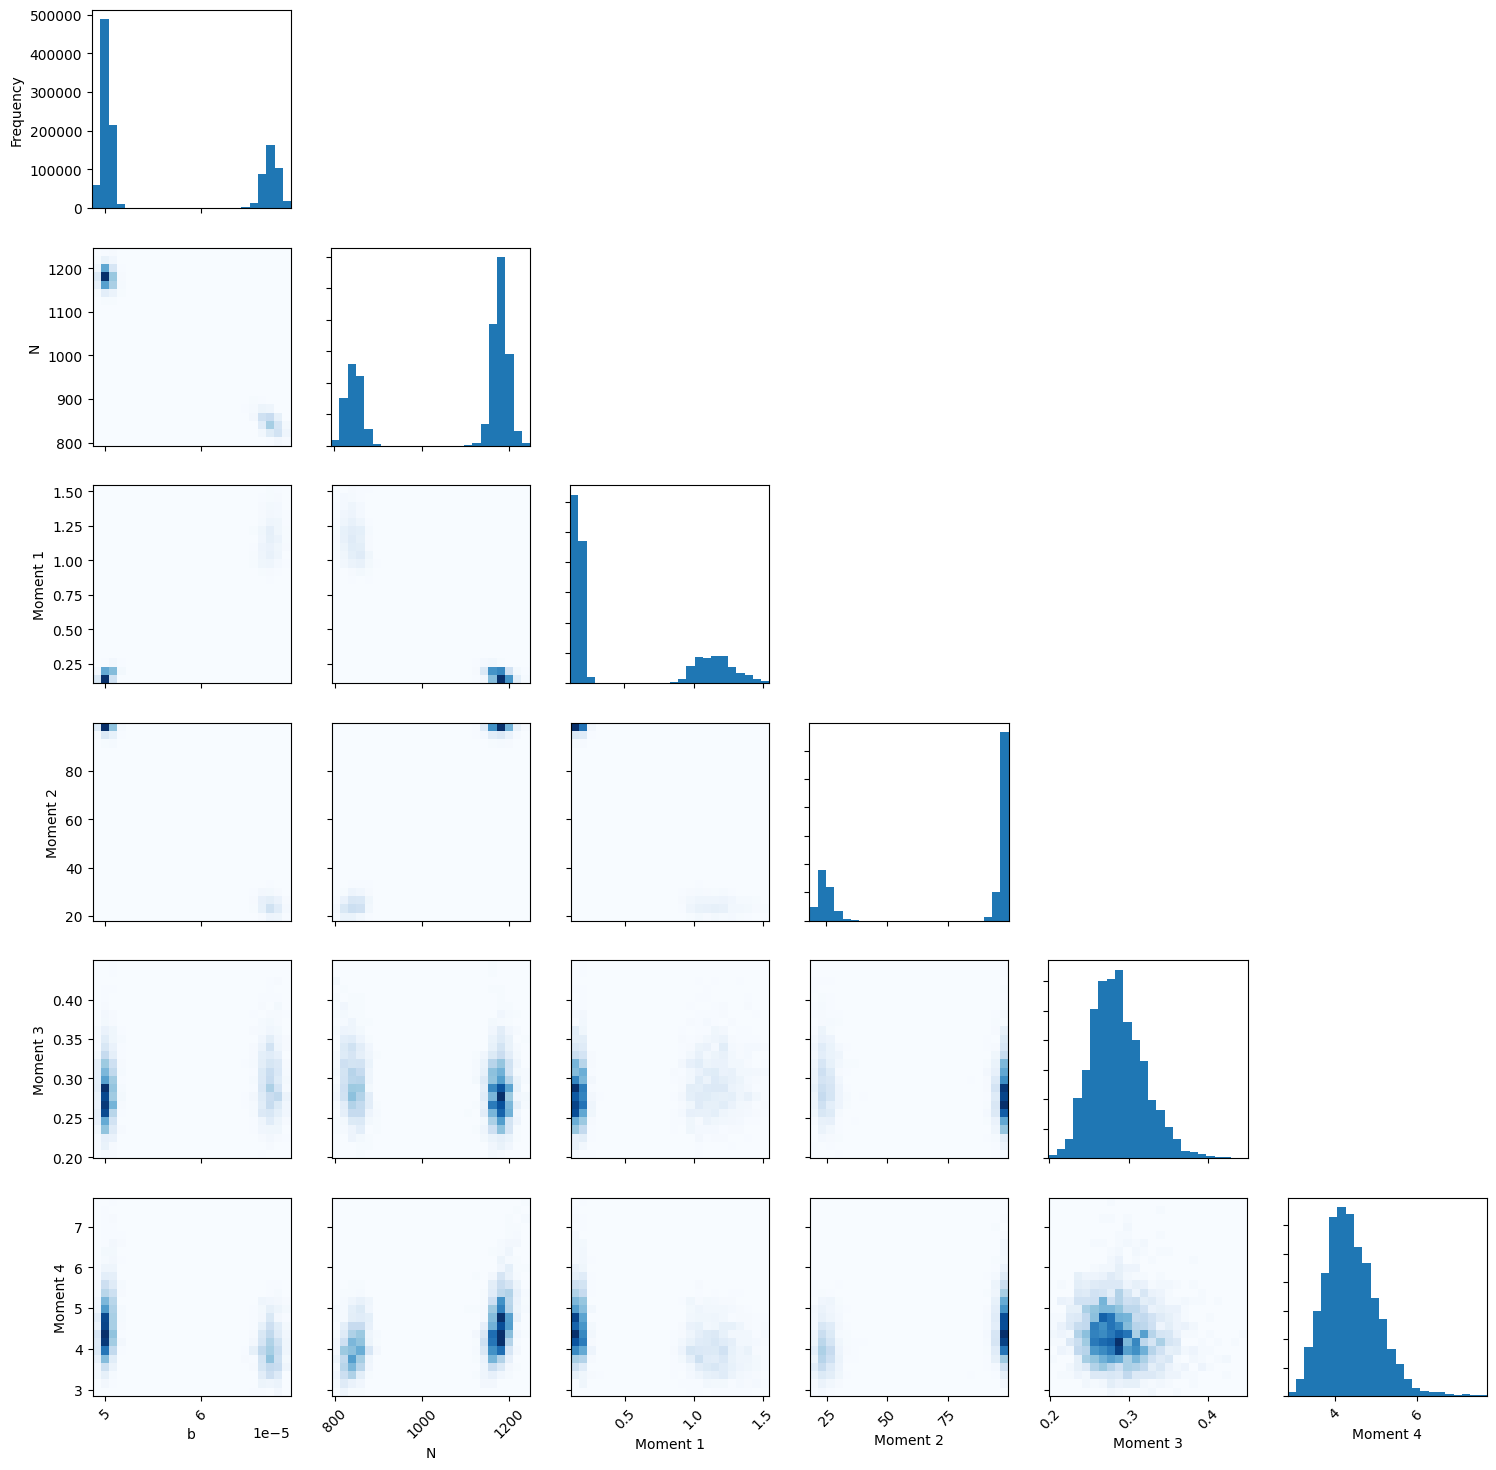

In [11]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

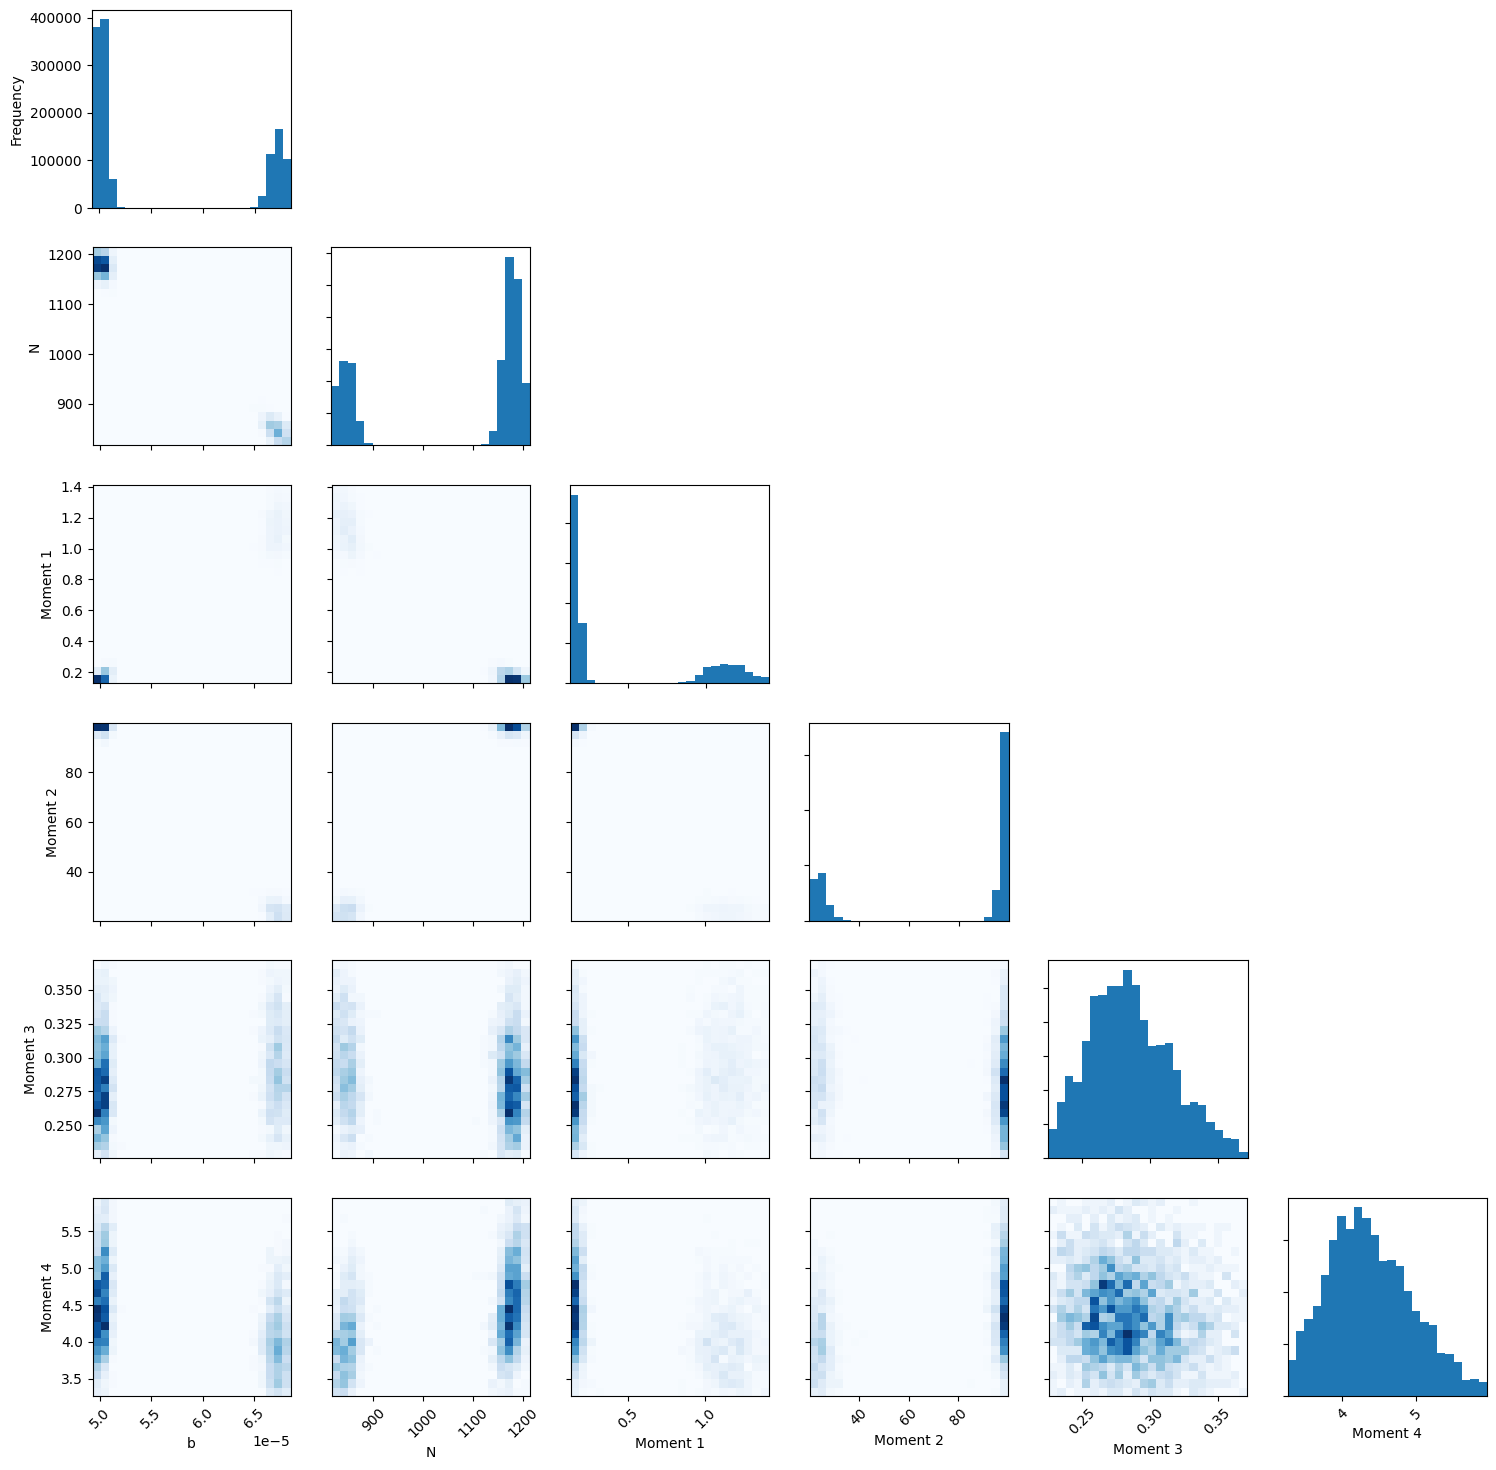

In [12]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

[4.98922302e-05 1.18791874e+03 1.67010021e-01 9.72772968e+01
 3.76970292e-01 4.02092347e+00]


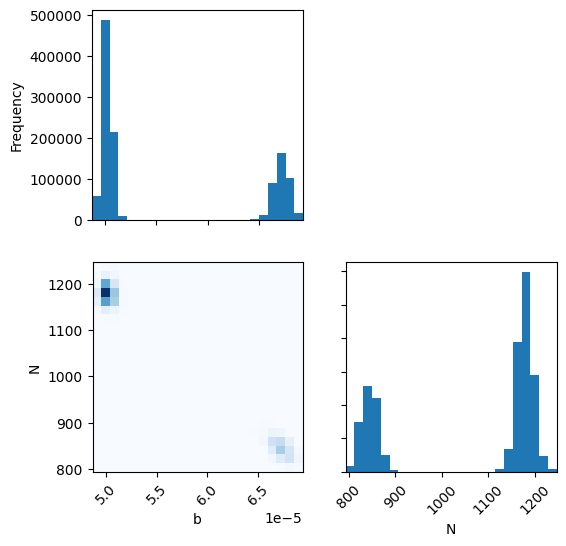

In [13]:
parameter_names = ["b","N"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1]], heatmap=True, 
                    parameter_names=["b","N"])
plt.savefig("Pints_pairwise_pro_params_only.png", dpi =300)
plt.show()


In [14]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean     std.    2.5%    25%     50%      75%      97.5%    rhat    ess     ess per sec.
--------  -------  ------  ------  ------  -------  -------  -------  ------  ------  --------------
b         0.00     0.00    0.00    0.00    0.00     0.00     0.00     15.04   377.08  0.43
N         1068.11  158.56  821.71  856.87  1168.51  1184.51  1210.57  10.06   339.24  0.39
Moment 1  0.50     0.47    0.13    0.16    0.18     1.05     1.37     6.55    364.81  0.42
Moment 2  73.69    34.75   20.91   26.22   97.45    99.20    99.91    17.16   315.93  0.36
Moment 3  0.29     0.03    0.23    0.26    0.28     0.31     0.36     1.02    415.64  0.48
Moment 4  4.39     0.63    3.31    3.95    4.32     4.77     5.75     1.11    394.86  0.45


In [15]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [16]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%    50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  -----  --------  --------  --------  ------  -----  --------------
b         5.59e-05  8.06e-06  4.94e-05  5e-05  5.05e-05  6.67e-05  6.84e-05  15      377    0.433
N         1.07e+03  159       822       857    1.17e+03  1.18e+03  1.21e+03  10.1    339    0.389
Moment 1  0.498     0.472     0.132     0.159  0.182     1.05      1.37      6.55    365    0.419
Moment 2  73.7      34.7      20.9      26.2   97.4      99.2      99.9      17.2    316    0.362
Moment 3  0.288     0.0339    0.231     0.264  0.284     0.308     0.362     1.02    416    0.477
Moment 4  4.39      0.635     3.31      3.95   4.32      4.77      5.75      1.11    395    0.453


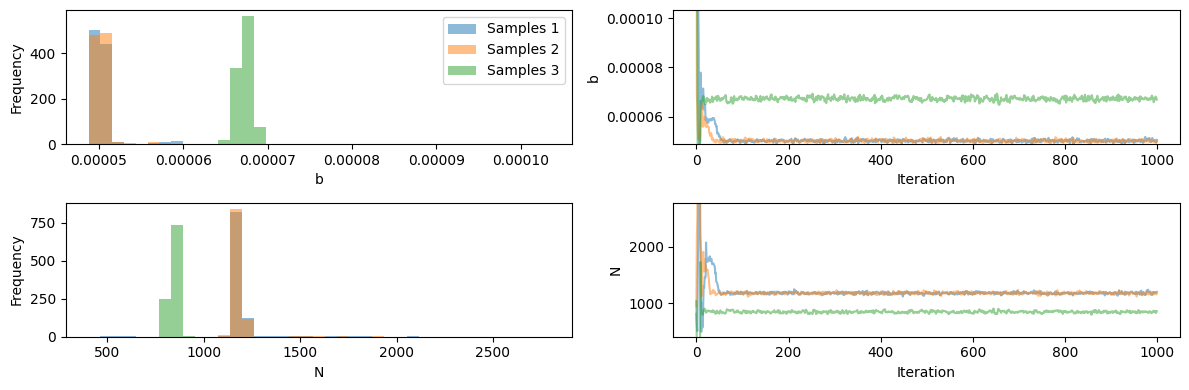

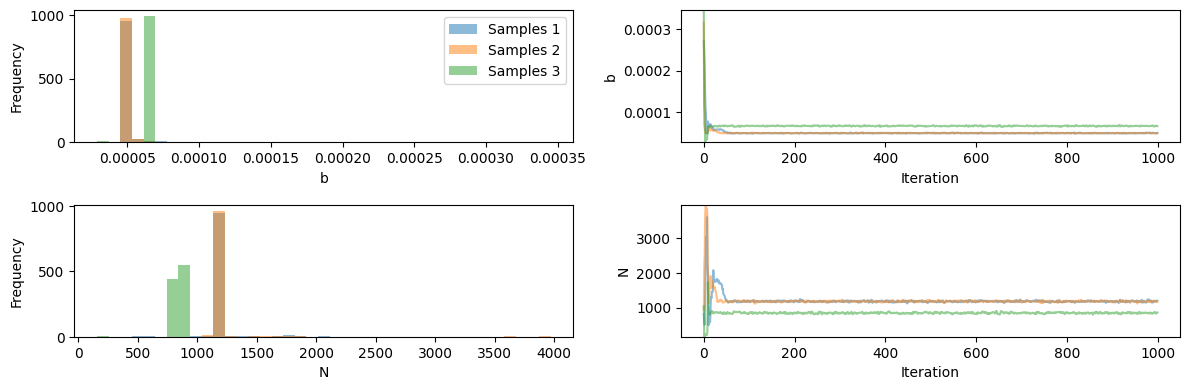

In [17]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()